In [1]:
import sys
sys.path.append('../')
from src import mlp_quantile
from src import metrics as _metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns

sns.set(rc={'figure.figsize':(20,8)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
pd.set_option('display.max_rows', 120)

* https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3
* https://towardsdatascience.com/lightgbm-for-quantile-regression-4288d0bb23fd
* https://towardsdatascience.com/deep-quantile-regression-in-tensorflow-1dbc792fe597
* https://github.com/sachinruk/KerasQuantileModel/blob/master/Keras%20Quantile%20Model.ipynb

## Reading / Displaying the Data 

In [2]:
df_dataset_v2 = pd.read_csv('../data/forecast_dataset_exp1.csv')

In [3]:
df_dataset_v2.describe()

,month,unit_markup,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,hc_cluster_6,hc_cluster_7,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
count,10938.000000,10938.000000,10938.000000,10938.000000,10938.000000,10938.000000,10938.000000,10938.000000,10938.000000,10938.000000,...,10938.000000,10938.000000,10938.000000,10938.000000,10938.000000,10938.000000,10938.000000,10938.000000,10938.000000,10938.000000
mean,6.237338,1.696480,13.862498,0.884440,0.004663,0.014445,0.004754,0.009508,0.020570,0.001463,...,0.002926,0.001828,0.003748,0.056409,0.009508,0.020570,0.001463,0.003383,0.011062,0.004663
std,3.635111,0.415631,34.969990,0.319712,0.068127,0.119322,0.068789,0.097049,0.141948,0.038220,...,0.054012,0.042724,0.061112,0.230720,0.097049,0.141948,0.038220,0.058065,0.104599,0.068127
min,1.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.400000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,1.700000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,2.000000,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,4.800000,643.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df_dataset_v2.head()

,code,year_month,month,unit_markup,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.1,53,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.2,92,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.3,28,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.4,61,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.5,21,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_cols = [c for c in df_dataset_v2.columns if c not in ['year_month', 'Y'] and 'hc_cluster' not in c]

In [6]:
df_dataset_v2['code'] = df_dataset_v2['code'].astype('category').cat.codes

In [7]:
df_dataset_v2[X_cols].head()

,code,month,unit_markup,kmeans_cluster_0,kmeans_cluster_1,kmeans_cluster_2,kmeans_cluster_3,kmeans_cluster_4,kmeans_cluster_5,kmeans_cluster_6,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0,11,1.1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,11,1.2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,11,1.3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,11,1.4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,11,1.5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the Sets
* We will use the temporal series cross validation
* 3 months minimum intervals
* 3 training, 6 validation, 3 test
* 4 training, 5 validation, 3 test
* 5 training, 4 validation, 3 test
* 6 training, 3 validation, 3 test

In [8]:
df_train_val_test = pd.read_csv('../data/train_val_test.csv')

In [9]:
df_train_val_test

,set,train,val,reserved
0,0,"['2016-06', '2016-07', '2016-08']","['2016-09', '2016-10', '2016-11', '2016-12', '...",False
1,1,"['2016-06', '2016-07', '2016-08', '2016-09']","['2016-10', '2016-11', '2016-12', '2017-01', '...",False
2,2,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-11', '2016-12', '2017-01', '2017-02']",False
3,3,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-12', '2017-01', '2017-02']",False
4,4,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-01', '2017-02']",False
5,5,"['2016-06', '2016-07', '2016-08', '2016-09', '...",['2017-02'],False
6,6,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-03', '2017-04', '2017-05']",True


## Regressors Init

In [10]:
regressors = {}
RANDOM_STATE = 42
q =0.5

In [11]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)
regressors['gbm'] = gbm

In [12]:
import lightgbm as lgb
gbm_q = lgb.LGBMRegressor(alpha=q, objective = 'quantile',
    metric = 'quantile',random_state=RANDOM_STATE)
regressors['gbm_q'] = gbm_q

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
gb_q = GradientBoostingRegressor(loss='quantile', alpha=q)
regressors['gb_q'] = gb_q

In [14]:

mlp_q = mlp_quantile.QuantileModel(input_dims=len(X_cols), q=q)
regressors['mlp_q'] = mlp_q

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Train Eval



In [16]:
def parse_str_list(str_list):
    result = str_list.replace("'","").replace('[','').replace(']','').replace(' ', '').split(',')
    return result

In [17]:
sets = list(df_train_val_test[~df_train_val_test.reserved].set.values)
sets

[0, 1, 2, 3, 4, 5]

In [18]:
results = []
for r_name, r in regressors.items():
    for s in sets:
        df_set = df_train_val_test[~df_train_val_test.reserved & (df_train_val_test.set == s)]

        x_scaler = MinMaxScaler()
        
        train_years = parse_str_list(df_set.train.values[0])
        val_years = parse_str_list(df_set.val.values[0])
        print(f'Training {r_name} on set {s}')
        

        df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]
        df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    
        y_train = df_train['Y'].values    
        y_val = df_val['Y'].values
        
        if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
        else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
        print(f'Validating {r_name}  on set {s}')
        
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))
        
        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        results.append(m)

    print()
df_results = pd.DataFrame(results)    

Training gbm on set 0
Validating gbm  on set 0
Training gbm on set 1
Validating gbm  on set 1
Training gbm on set 2
Validating gbm  on set 2
Training gbm on set 3
Validating gbm  on set 3
Training gbm on set 4
Validating gbm  on set 4
Training gbm on set 5
Validating gbm  on set 5

Training gbm_q on set 0
Validating gbm_q  on set 0
Training gbm_q on set 1
Validating gbm_q  on set 1
Training gbm_q on set 2
Validating gbm_q  on set 2
Training gbm_q on set 3
Validating gbm_q  on set 3
Training gbm_q on set 4
Validating gbm_q  on set 4
Training gbm_q on set 5
Validating gbm_q  on set 5

Training gb_q on set 0
Validating gb_q  on set 0
Training gb_q on set 1
Validating gb_q  on set 1
Training gb_q on set 2
Validating gb_q  on set 2
Training gb_q on set 3
Validating gb_q  on set 3
Training gb_q on set 4
Validating gb_q  on set 4
Training gb_q on set 5
Validating gb_q  on set 5

Training mlp_q on set 0
Validating mlp_q  on set 0
Training mlp_q on set 1
Validating mlp_q  on set 1
Training mlp_

In [19]:
metric_list = []

In [20]:
df_results.groupby('r_name').agg({'RMSE':[pd.Series.mean, pd.Series.std],
                                  'MDAPE':[pd.Series.mean, pd.Series.std],'MAPE':[pd.Series.mean, pd.Series.std],
                                  'MSE':[pd.Series.mean, pd.Series.std],
                                  'MAE':[pd.Series.mean, pd.Series.std],'R2':[pd.Series.mean, pd.Series.std],})

RMSE               MDAPE                MAPE            \
             mean       std      mean       std      mean       std   
r_name                                                                
gb_q    32.437636  3.459011  0.670940  0.010468  1.145721  0.122876   
gbm     24.487217  4.245123  0.867104  0.077169  2.418578  0.192851   
gbm_q   28.240207  3.761590  0.667659  0.028276  1.328513  0.093124   
mlp_q   35.863793  5.851484  1.218480  0.703421  2.639387  2.475702   

                MSE                    MAE                  R2            
               mean         std       mean       std      mean       std  
r_name                                                                    
gb_q    1062.170863  207.915444  10.595091  1.391927  0.039580  0.029423  
gbm      614.641333  185.099653  10.900619  1.560215  0.455472  0.095112  
gbm_q    809.300565  191.608084  10.127103  1.476508  0.274489  0.065390  
mlp_q   1314.744899  413.556109  14.511352  5.743906 -0.177693  0.252288

Training gbm on set 6
Validating gbm on set 6 and 2017-03
7626 1073
RMSE : 22.9808
MAPE': 1.8057
MDAPE': 0.6667
MSE: 528.1193
MAE: 9.3122
R2: 0.5472


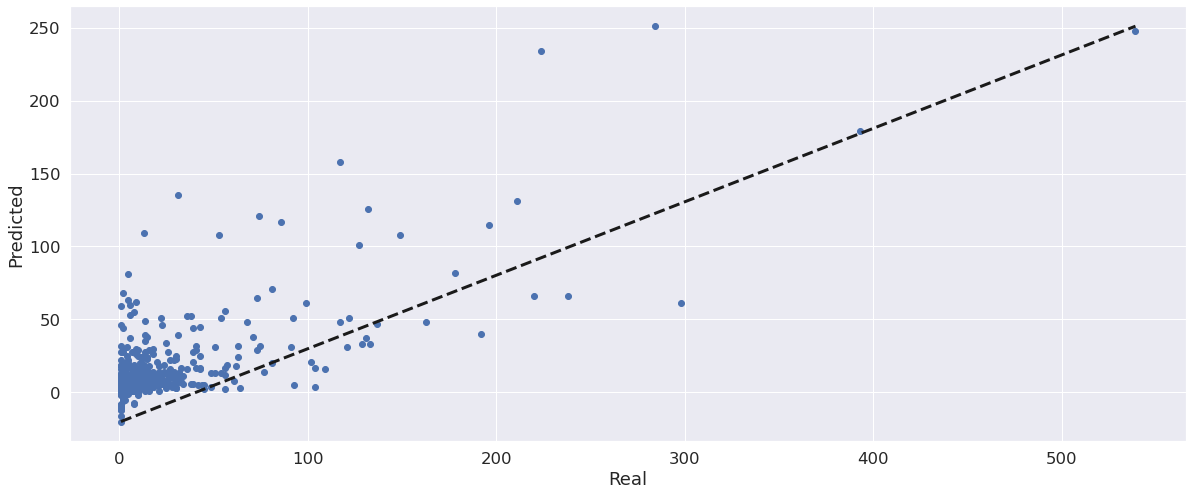

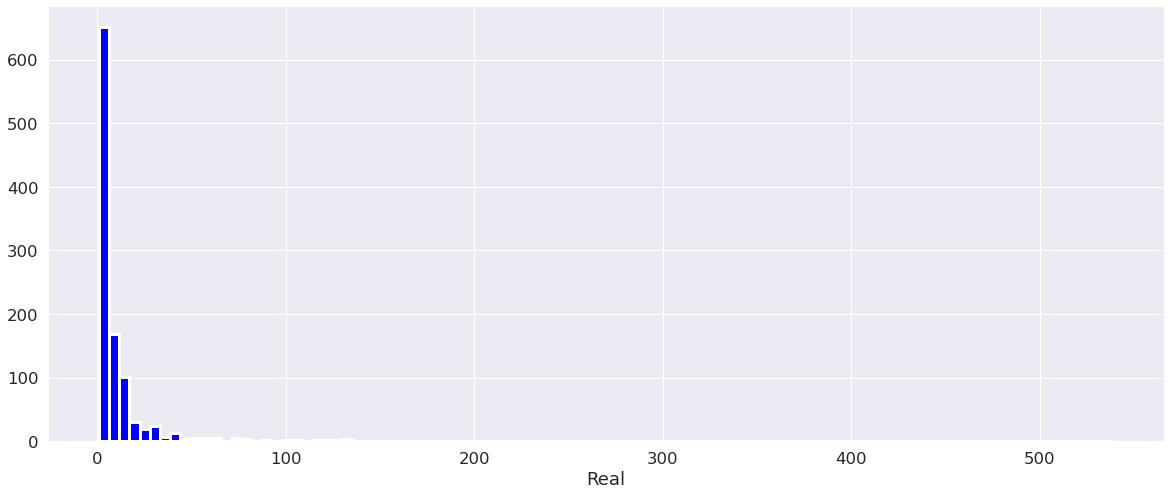

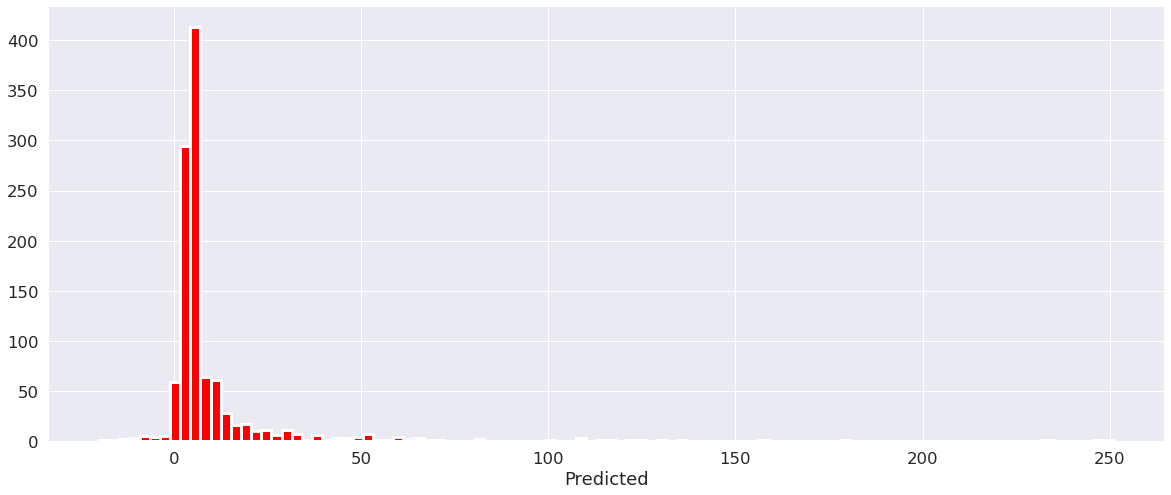


Validating gbm on set 6 and 2017-04
7626 1068
RMSE : 23.8973
MAPE': 2.0520
MDAPE': 0.7500
MSE: 571.0796
MAE: 9.4054
R2: 0.4027


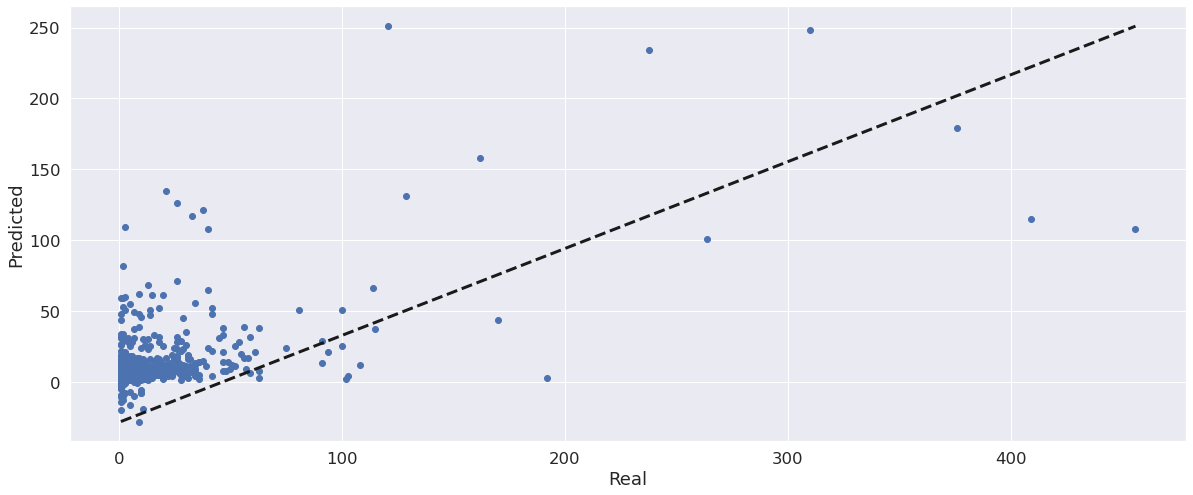

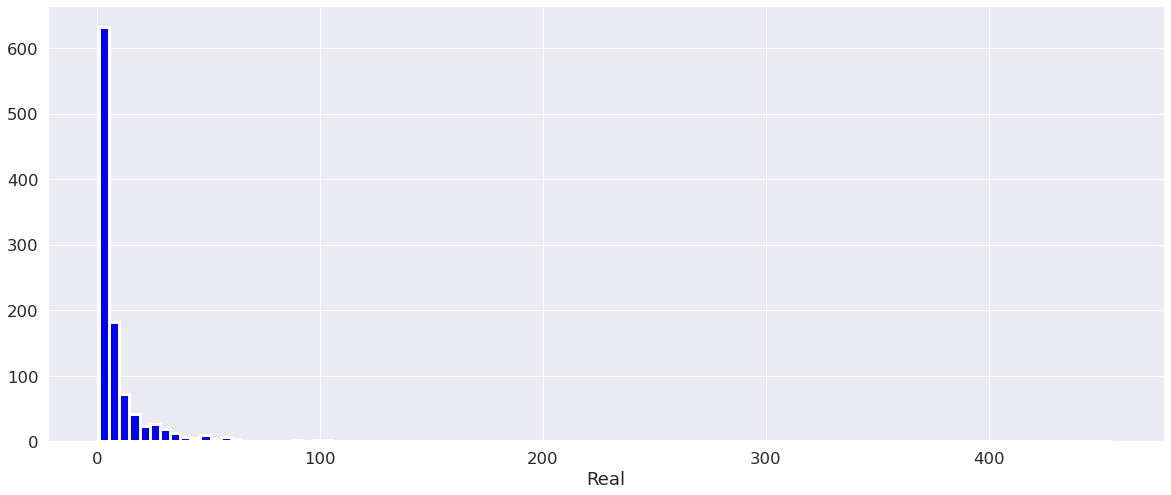

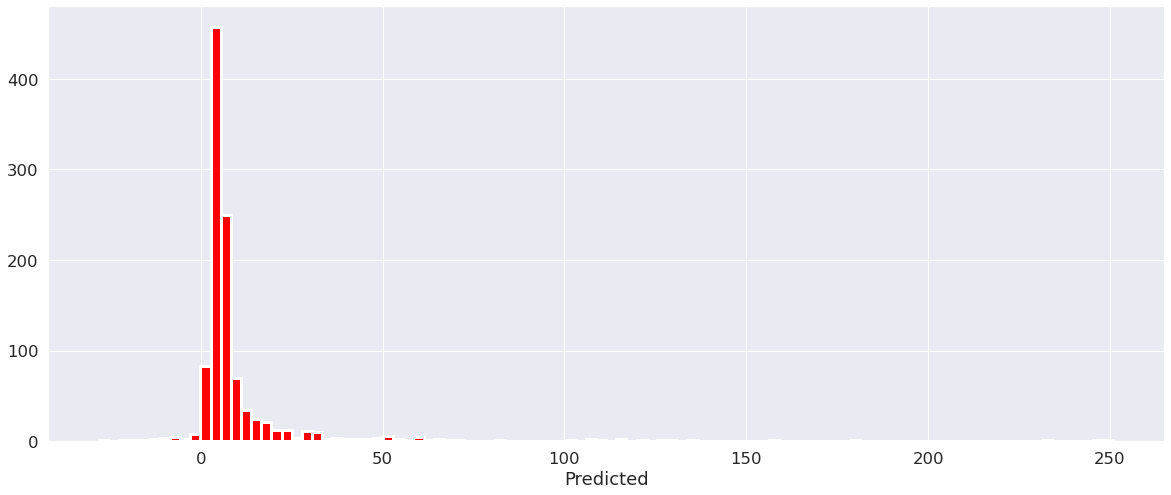


Validating gbm on set 6 and 2017-05
7626 1171
RMSE : 33.0765
MAPE': 1.7775
MDAPE': 0.6667
MSE: 1094.0521
MAE: 11.2989
R2: 0.3336


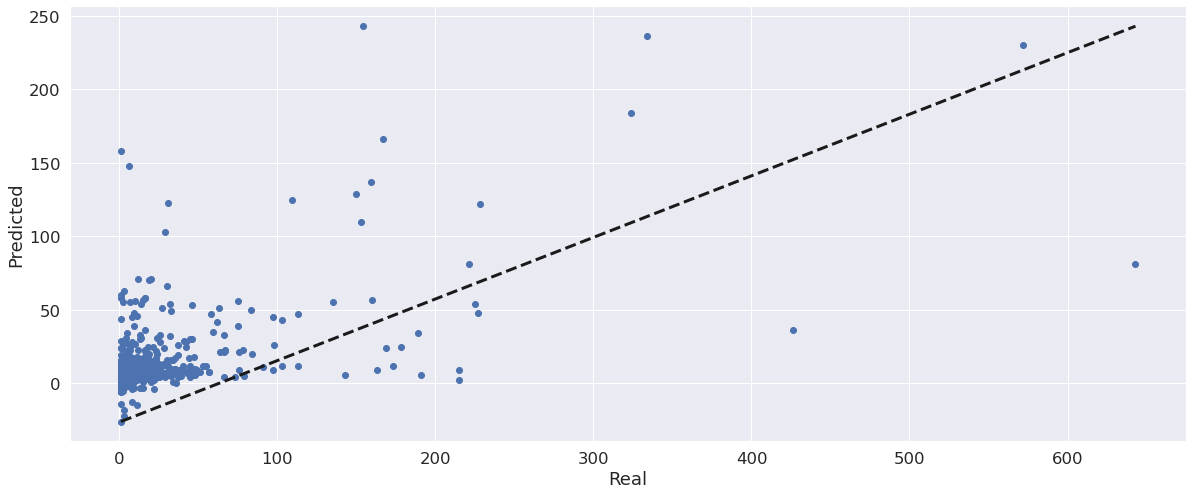

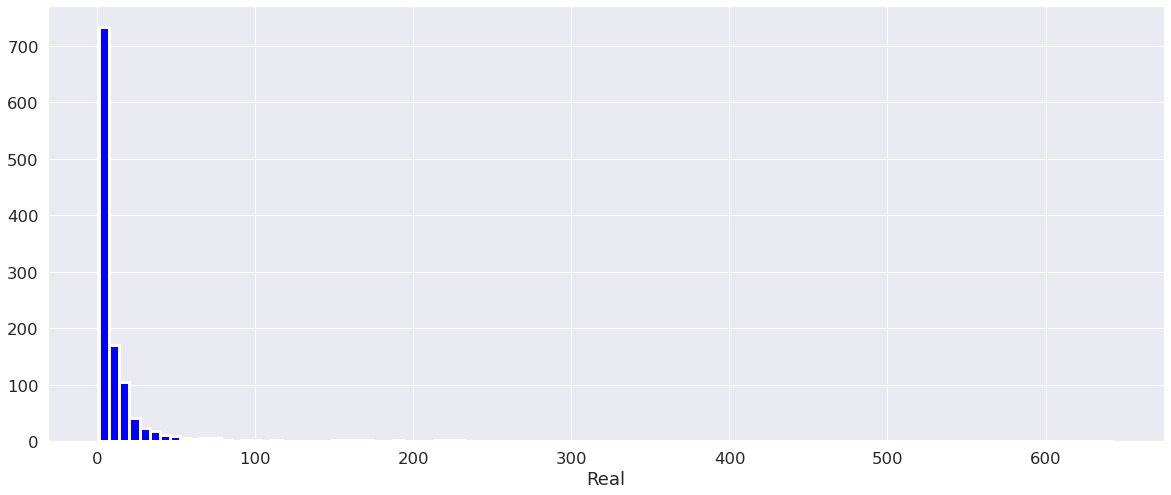

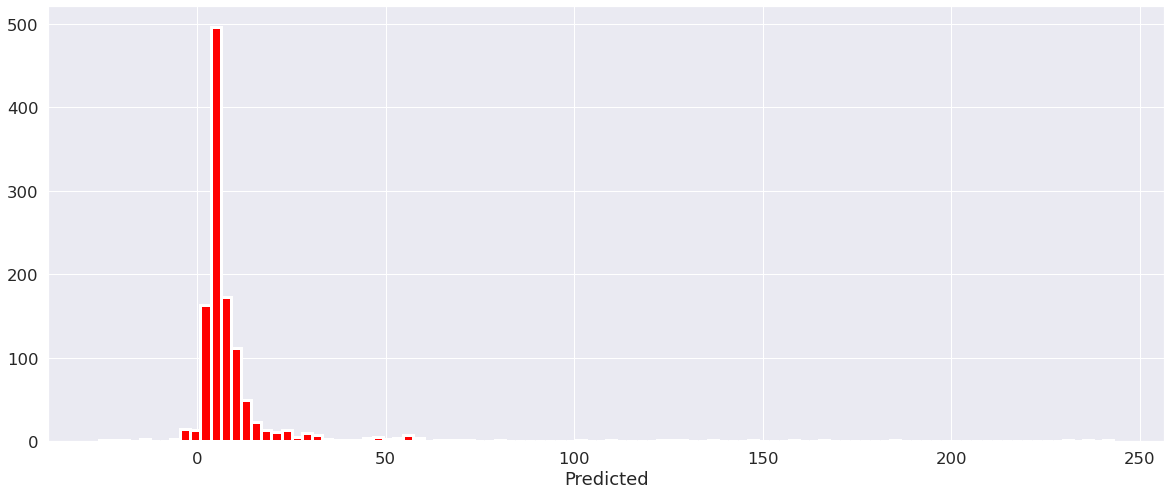


Training gbm_q on set 6
Validating gbm_q on set 6 and 2017-03
7626 1073
RMSE : 28.2152
MAPE': 1.1229
MDAPE': 0.6000
MSE: 796.0997
MAE: 9.4045
R2: 0.3175


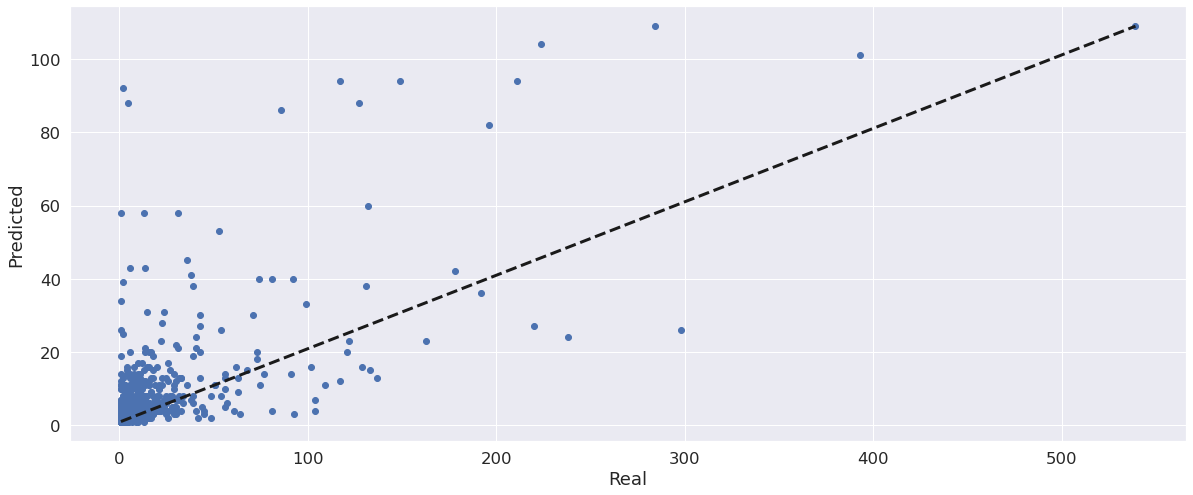

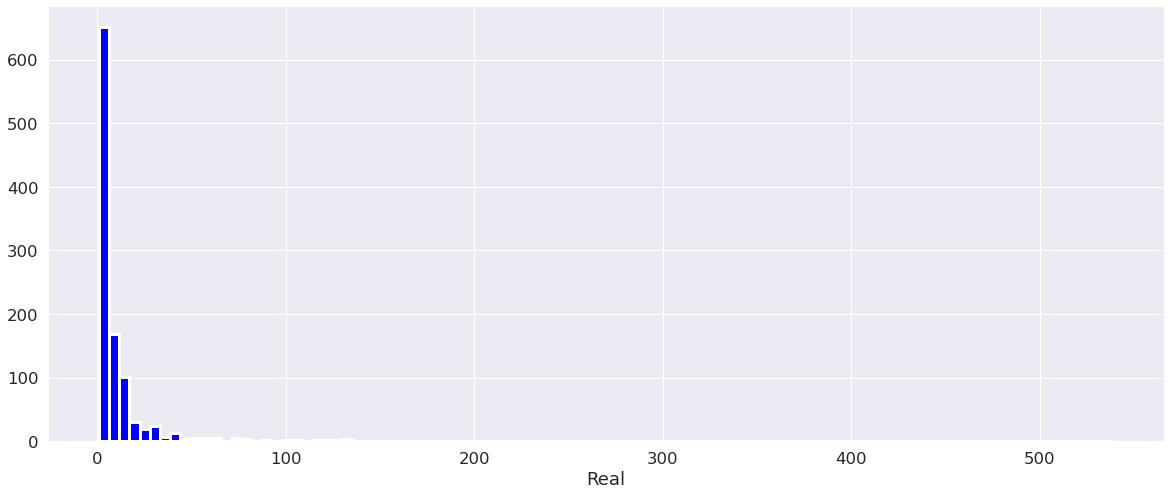

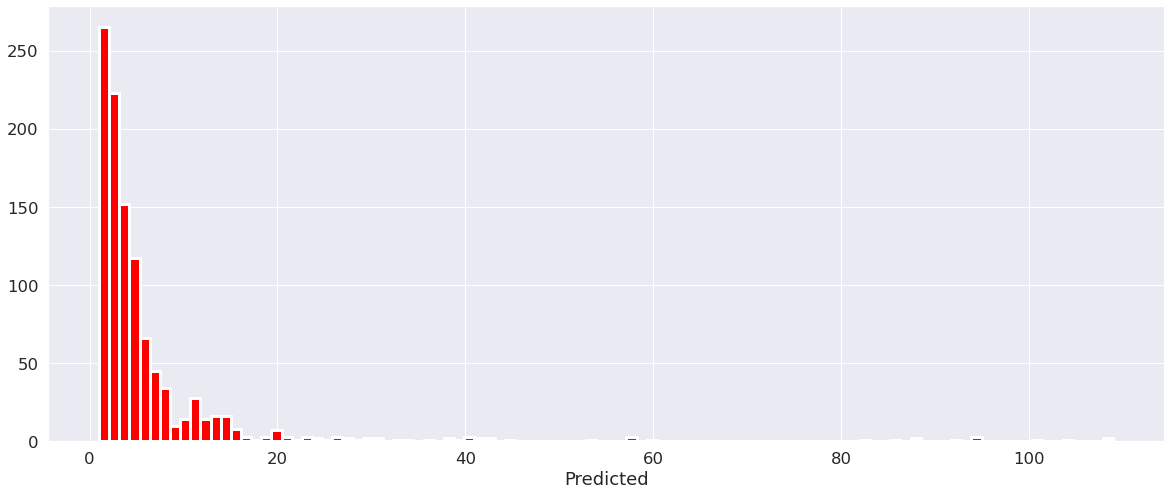


Validating gbm_q on set 6 and 2017-04
7626 1068
RMSE : 24.9476
MAPE': 1.2288
MDAPE': 0.6000
MSE: 622.3848
MAE: 8.4298
R2: 0.3490


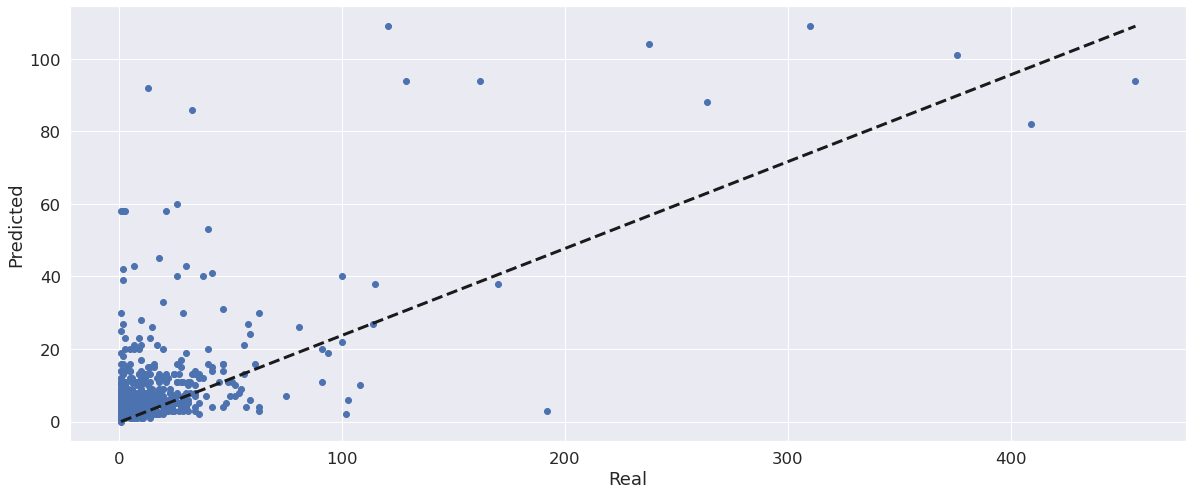

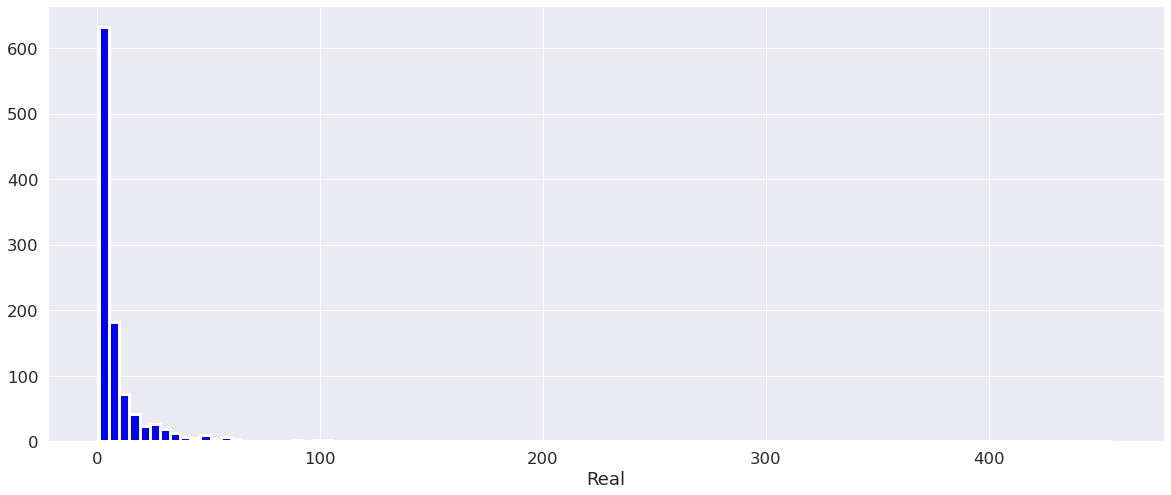

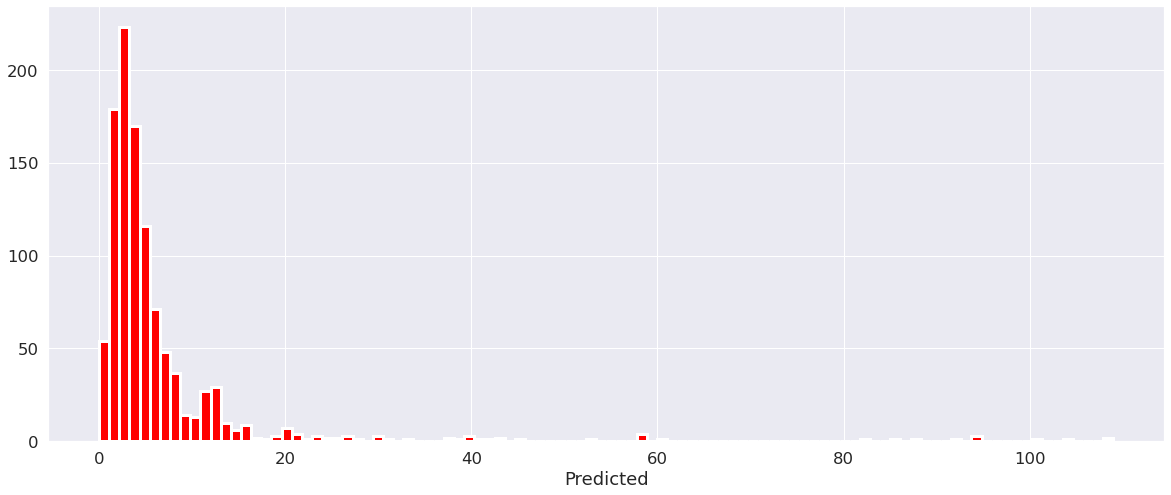


Validating gbm_q on set 6 and 2017-05
7626 1171
RMSE : 35.6755
MAPE': 1.0539
MDAPE': 0.6176
MSE: 1272.7404
MAE: 11.2306
R2: 0.2248


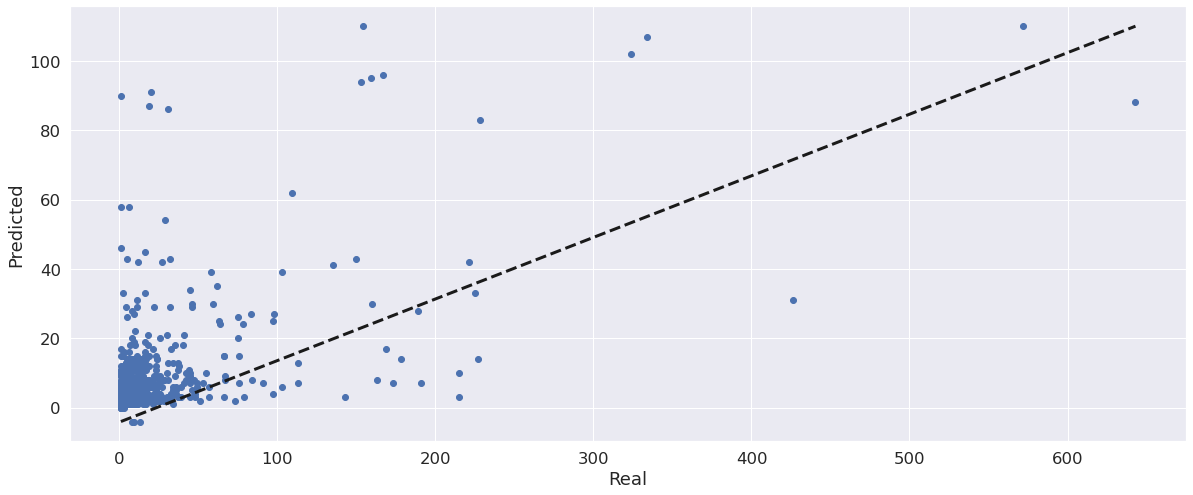

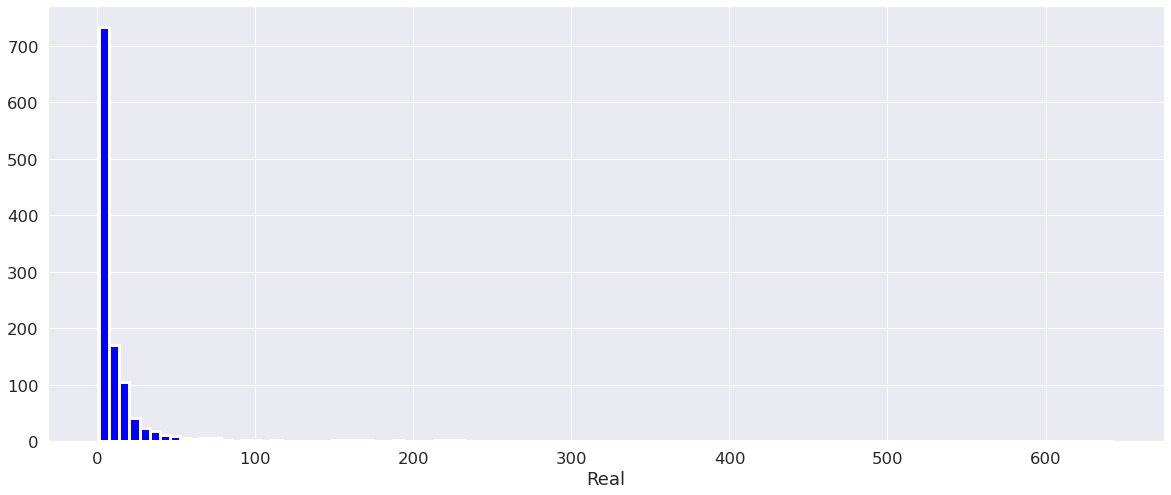

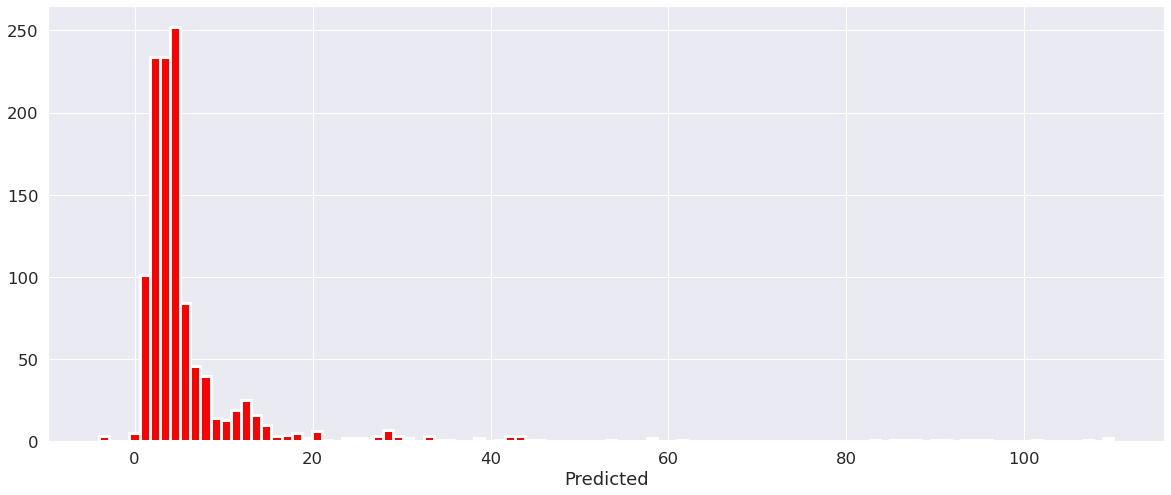


Training gb_q on set 6
Validating gb_q on set 6 and 2017-03
7626 1073
RMSE : 33.2305
MAPE': 1.1905
MDAPE': 0.6875
MSE: 1104.2628
MAE: 10.6263
R2: 0.0533


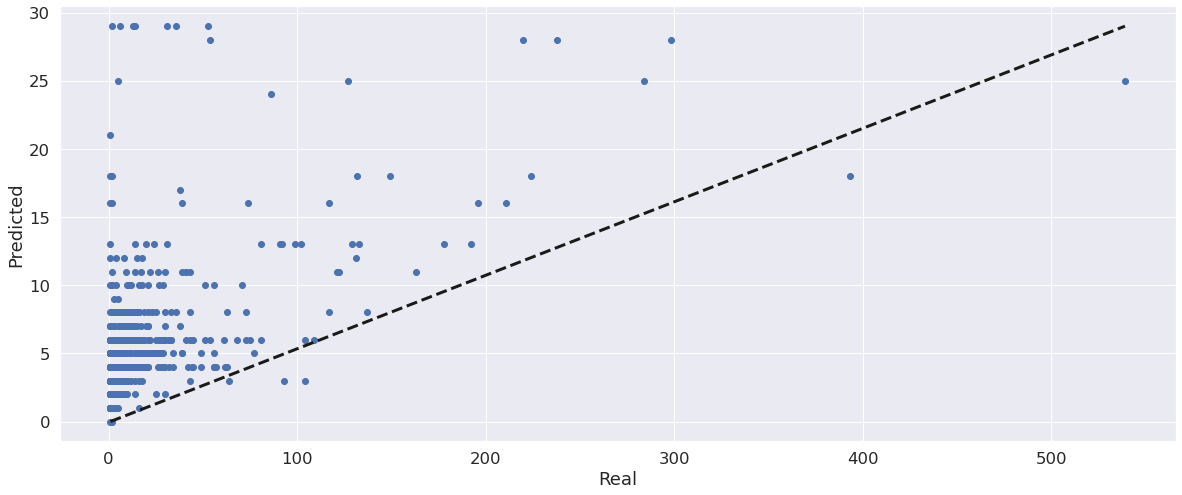

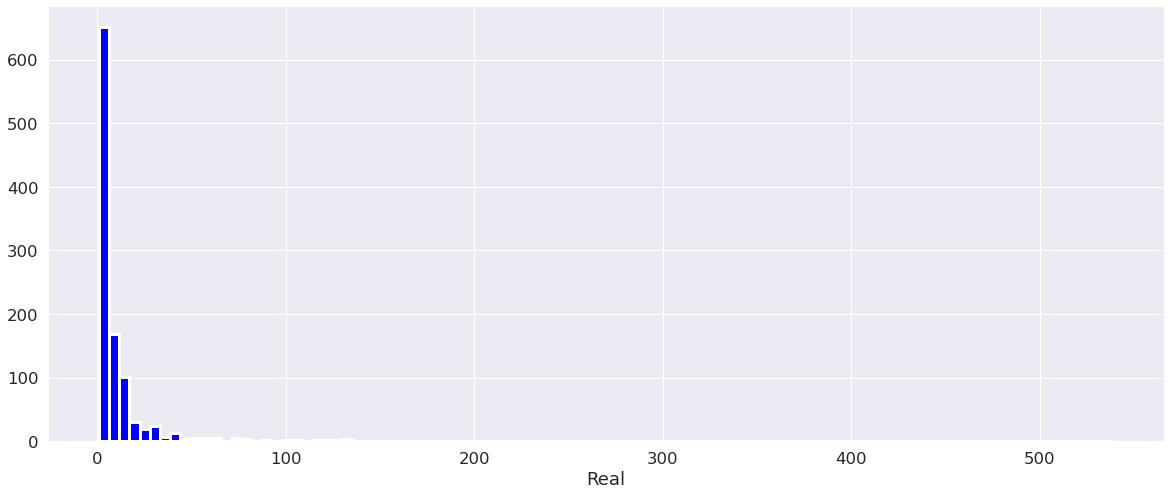

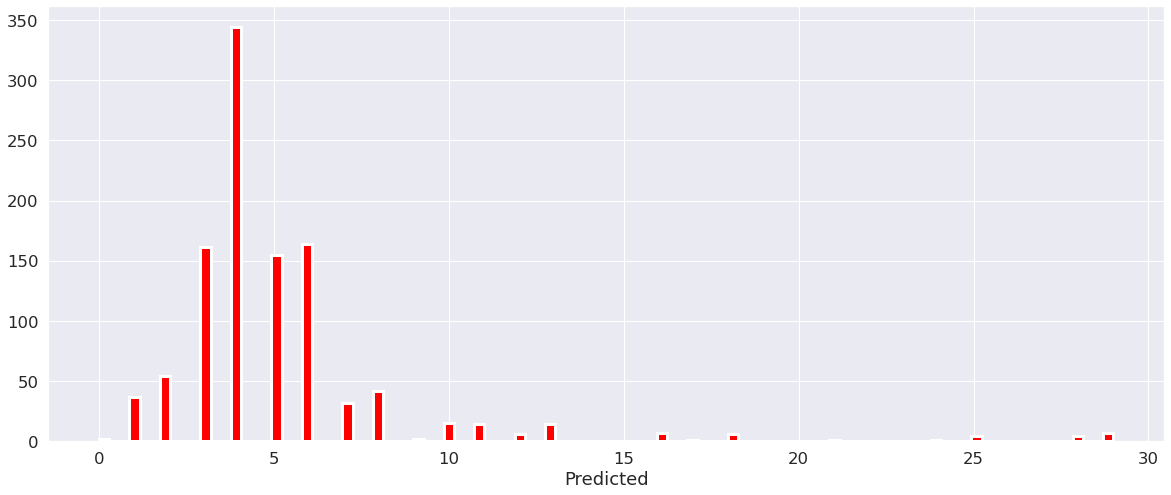


Validating gb_q on set 6 and 2017-04
7626 1068
RMSE : 30.1722
MAPE': 1.2024
MDAPE': 0.6787
MSE: 910.3642
MAE: 9.1620
R2: 0.0478


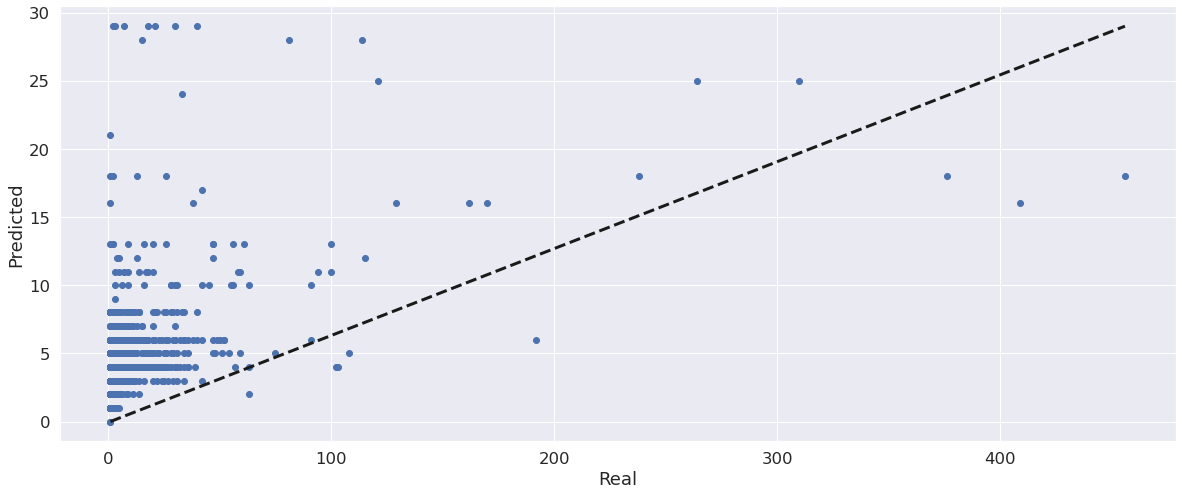

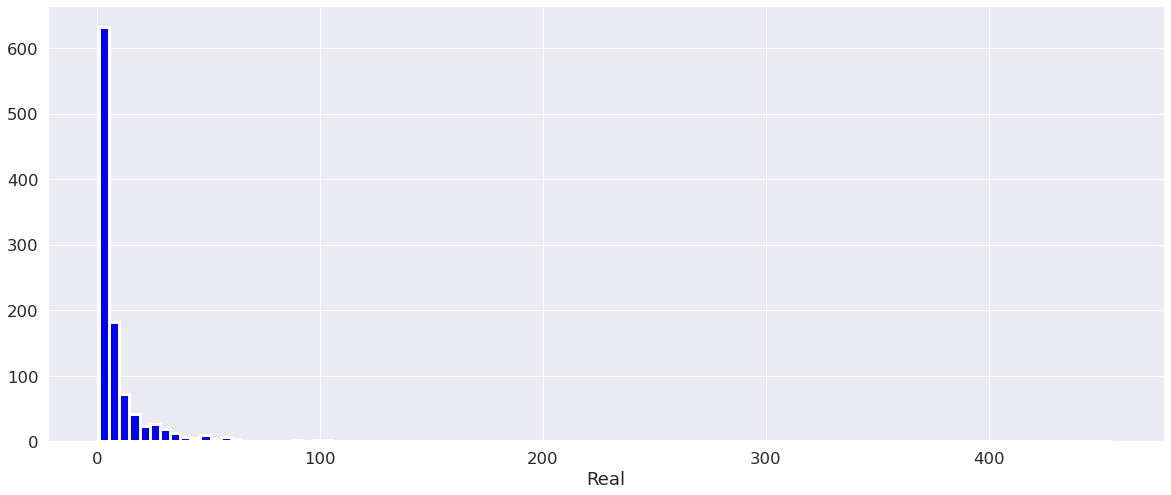

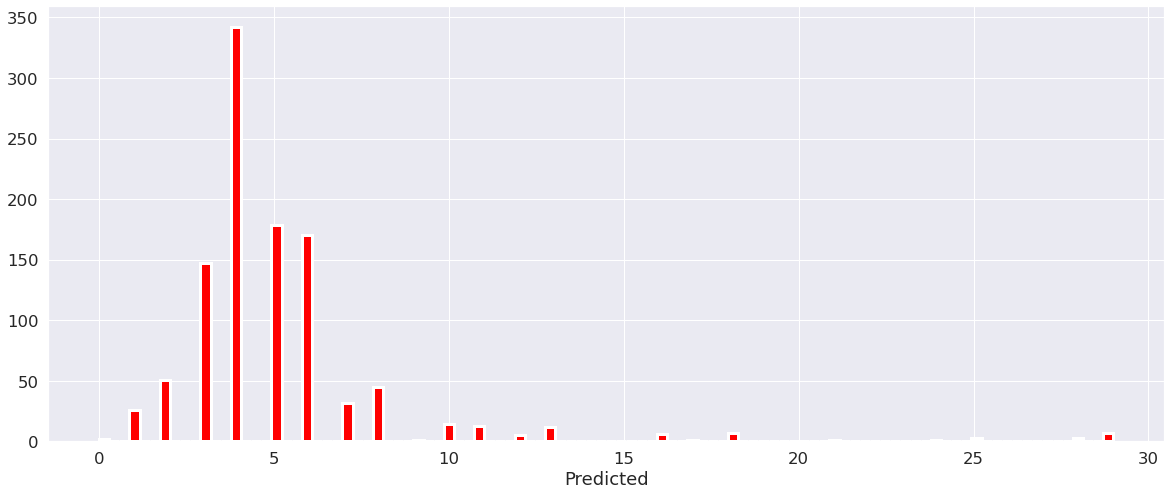


Validating gb_q on set 6 and 2017-05
7626 1171
RMSE : 40.2530
MAPE': 1.0009
MDAPE': 0.6667
MSE: 1620.3049
MAE: 11.8915
R2: 0.0131


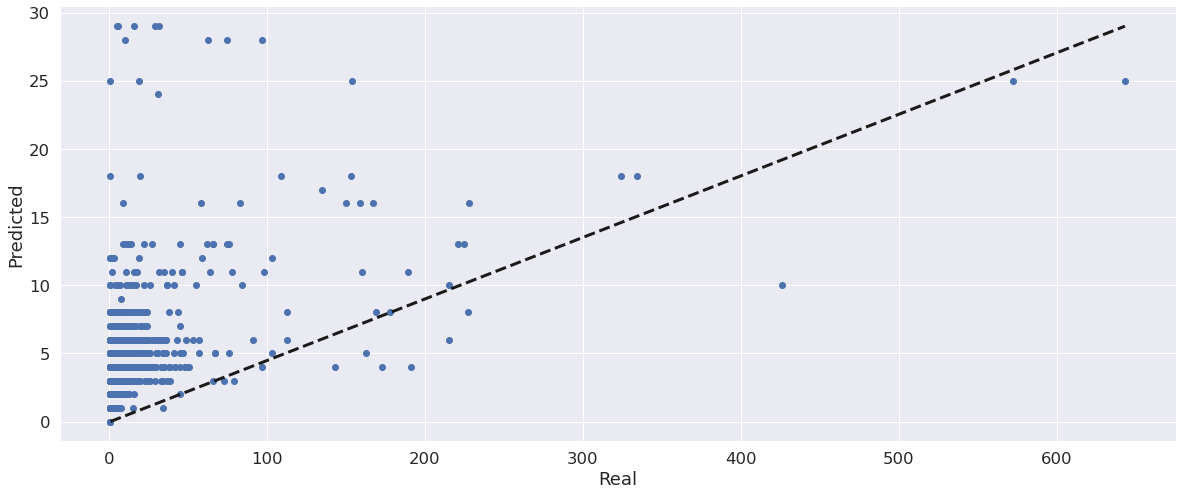

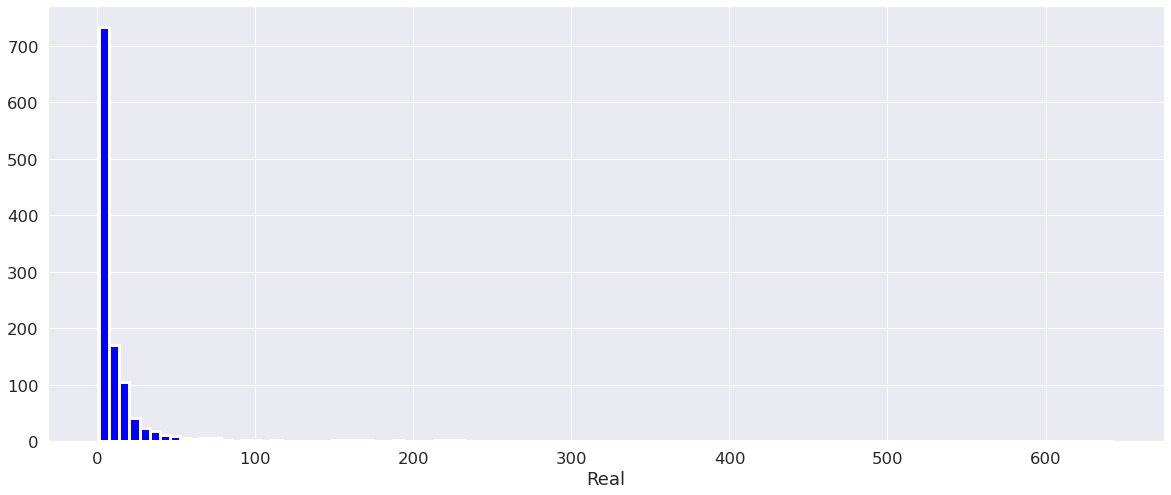

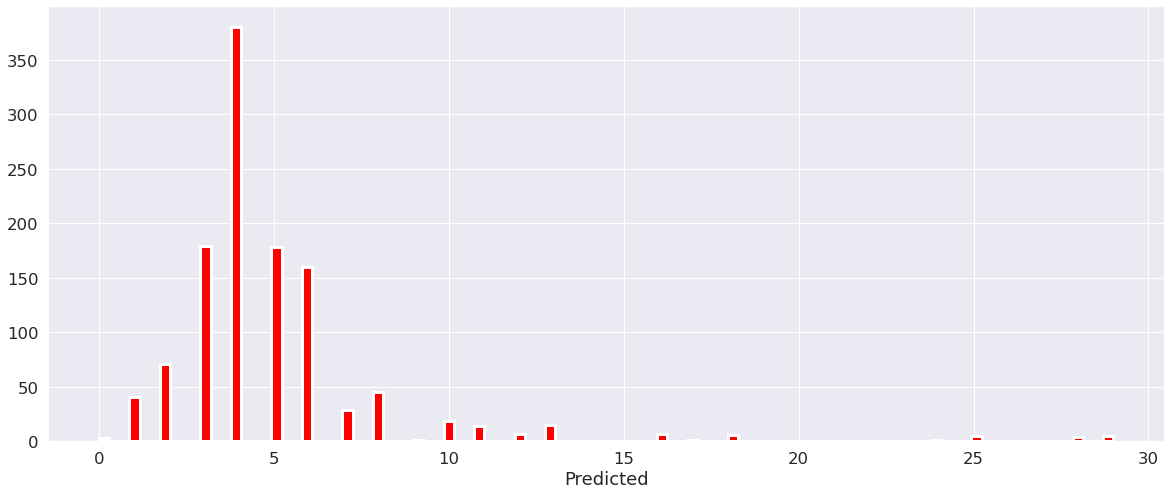


Training mlp_q on set 6
Validating mlp_q on set 6 and 2017-03
7626 1073
RMSE : 33.9680
MAPE': 1.4110
MDAPE': 0.7222
MSE: 1153.8239
MAE: 11.1305
R2: 0.0108


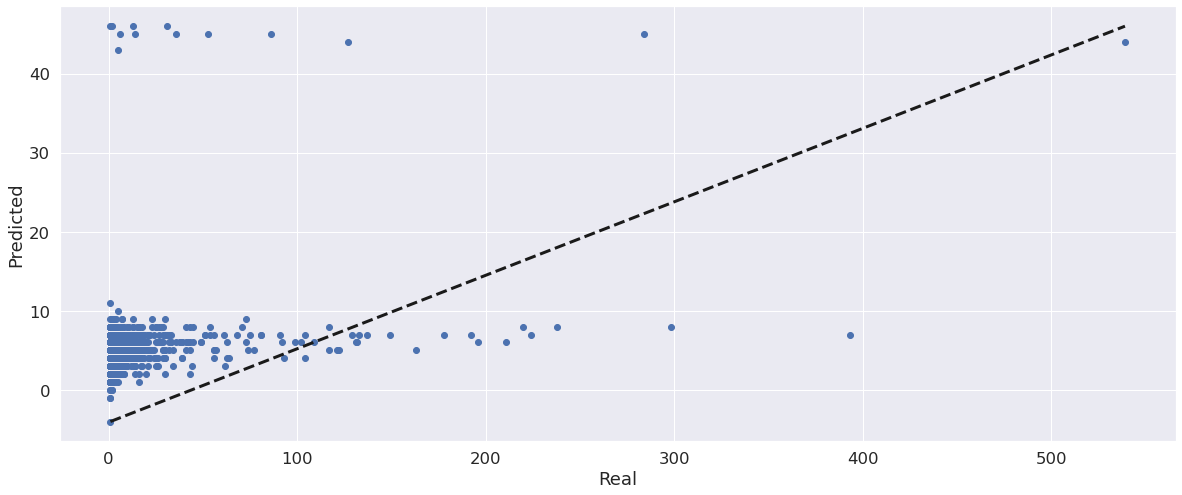

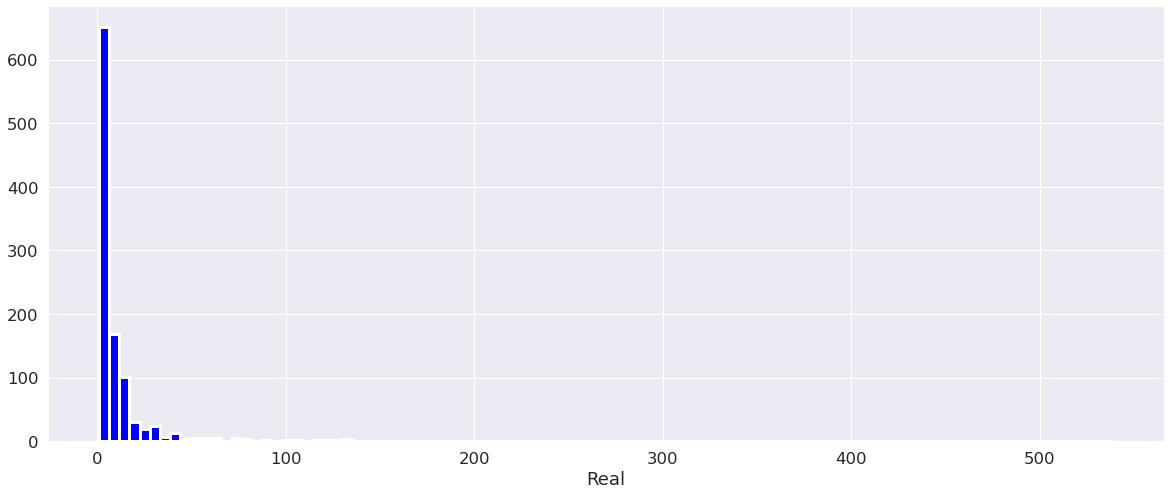

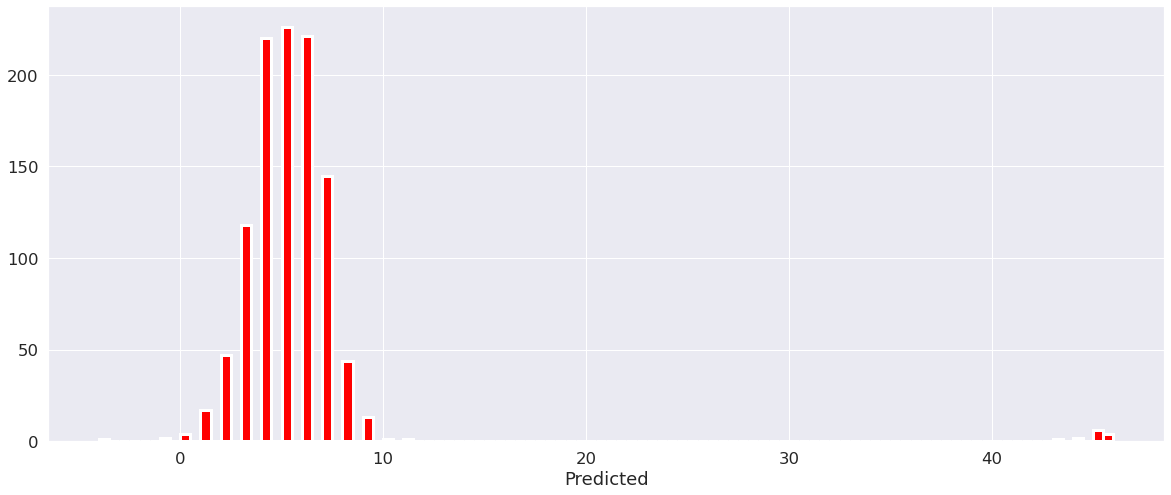


Validating mlp_q on set 6 and 2017-04
7626 1068
RMSE : 30.8221
MAPE': 1.3925
MDAPE': 0.7500
MSE: 950.0000
MAE: 9.6348
R2: 0.0064


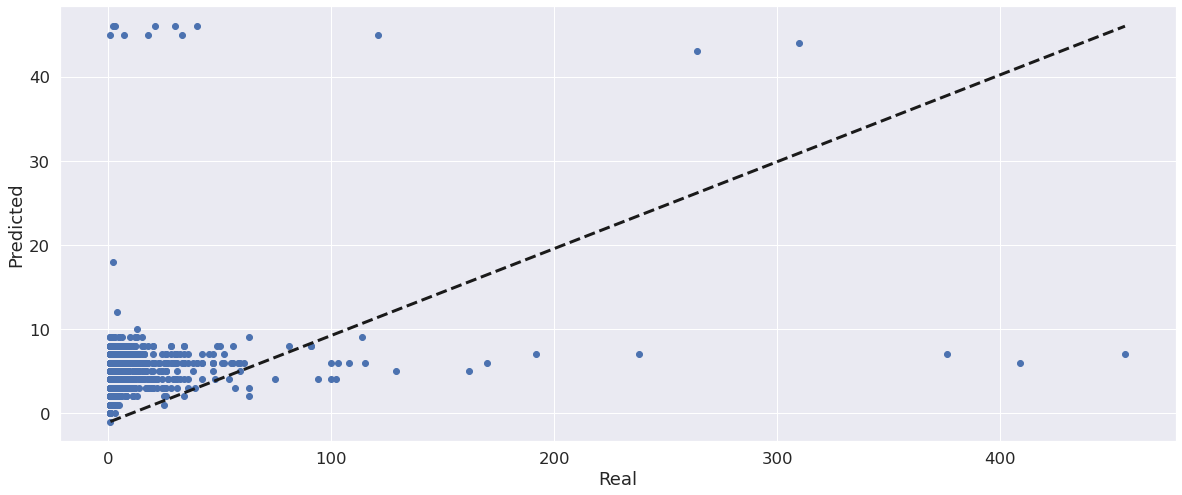

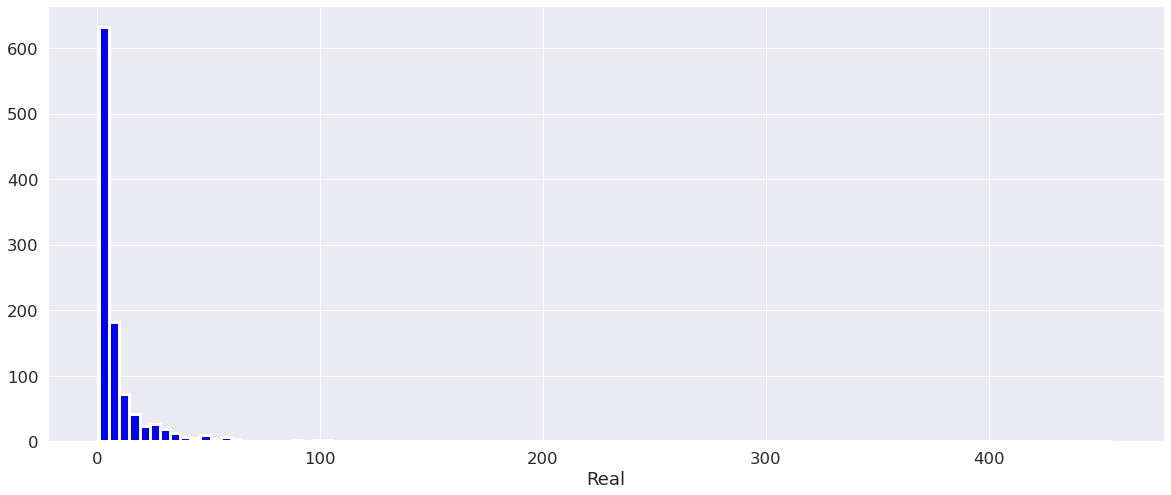

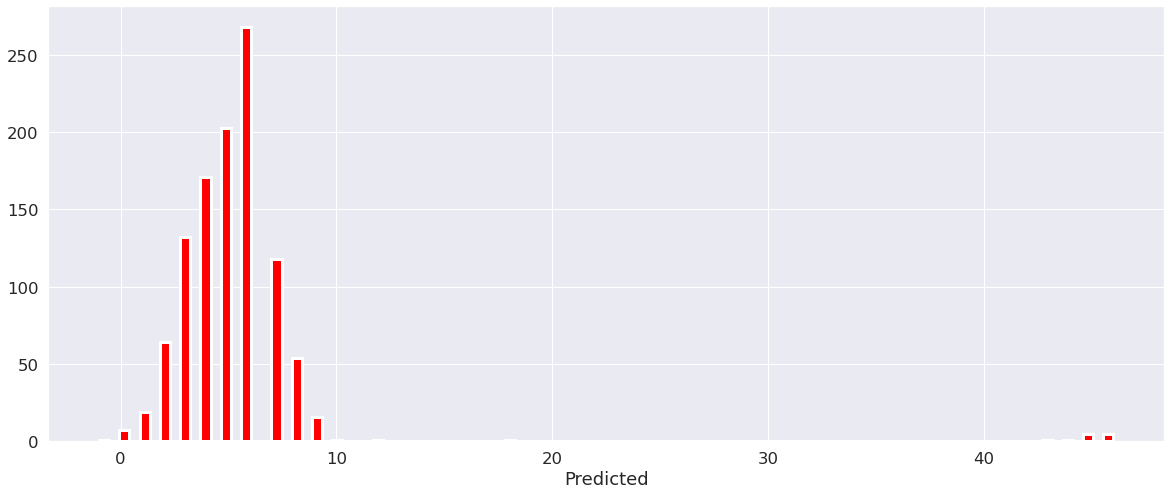


Validating mlp_q on set 6 and 2017-05
7626 1171
RMSE : 40.6172
MAPE': 1.1538
MDAPE': 0.6667
MSE: 1649.7592
MAE: 12.4458
R2: -0.0049


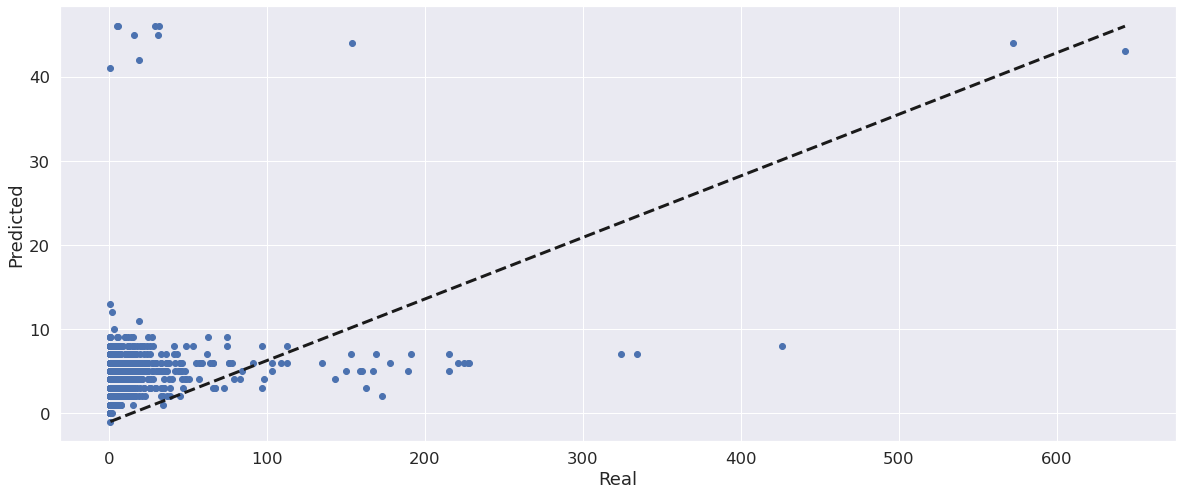

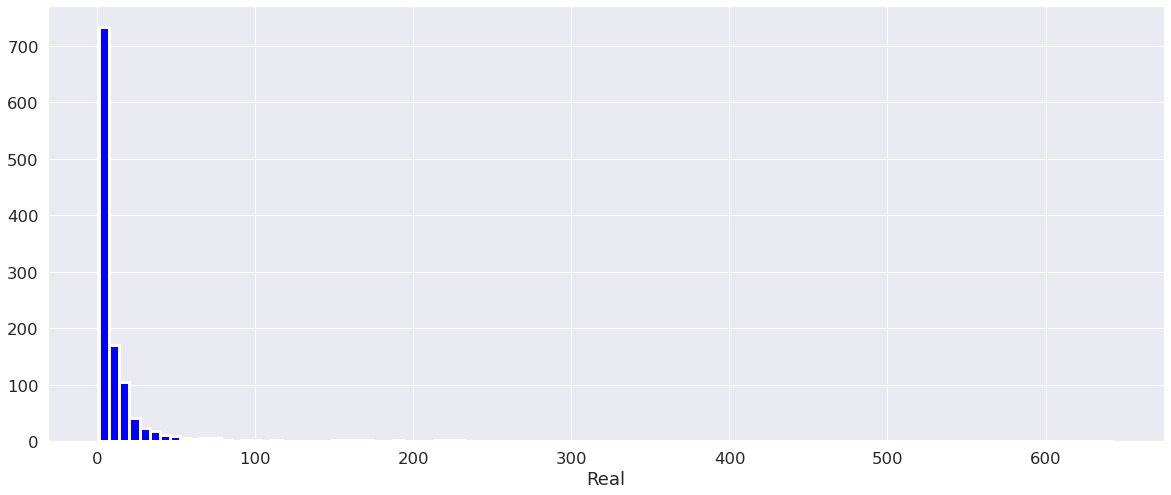

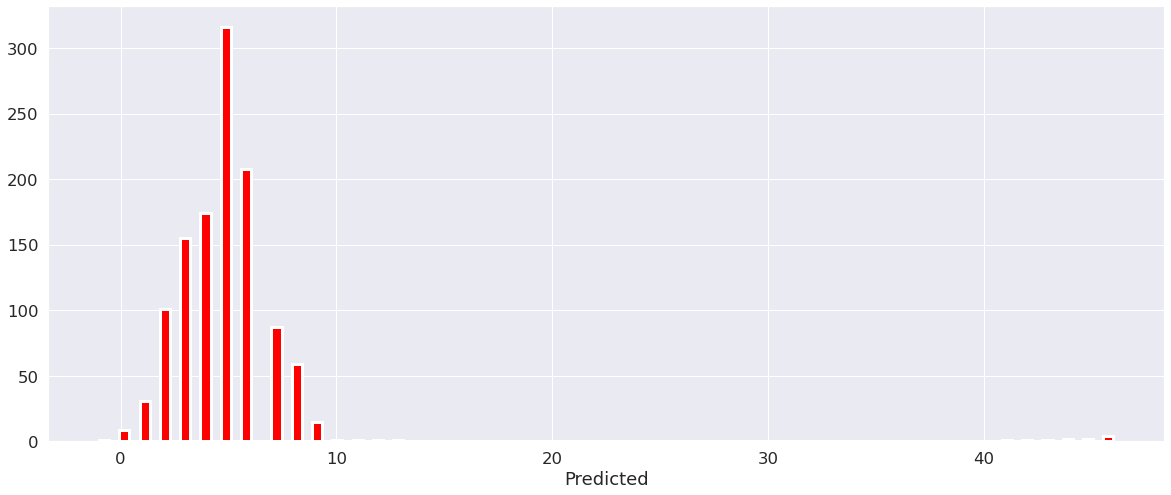

In [21]:
results = []
for r_name, r in regressors.items():
    s=6
    x_scaler = StandardScaler()

    df_set = df_train_val_test[(df_train_val_test.set == s)]

    x_scaler = MinMaxScaler()

    train_years = parse_str_list(df_set.train.values[0])
    val_years = parse_str_list(df_set.val.values[0])
    print(f'Training {r_name} on set {s}')

    df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]    

    y_train = df_train['Y'].values    
    df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    y_val = df_val['Y'].values
        
    if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
    else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
    for val_year in val_years:
        df_val = df_dataset_v2[df_dataset_v2.year_month == val_year]
        print(f'Validating {r_name} on set {s} and {val_year}')
        y_val = df_val['Y']
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))

        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        m['year_month'] = val_year
        results.append(m)
        print(len(y_train), len(y_val))
        _metrics.evaluateRegression(y=y_val, y_pred=y_pred_val)
        print()
df_results = pd.DataFrame(results)    

In [22]:
df_results[[c for c in df_results.columns if  c not in ['y', 'y_pred']]].sort_values('year_month')

,RMSE,MAPE,MDAPE,MSE,MAE,R2,reg_inst,r_name,set,year_month
0,22.980846,1.805678,0.666667,528.119292,9.312209,0.547232,LGBMRegressor(random_state=42),gbm,6,2017-03
3,28.215239,1.122869,0.600000,796.099720,9.404473,0.317487,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-03
6,33.230450,1.190459,0.687500,1104.262815,10.626281,0.053292,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-03
9,33.967983,1.410991,0.722222,1153.823858,11.130475,0.010802,<src.mlp_quantile.QuantileModel object at 0x7f...,mlp_q,6,2017-03
1,23.897272,2.051977,0.750000,571.079588,9.405431,0.402697,LGBMRegressor(random_state=42),gbm,6,2017-04
4,24.947642,1.228845,0.600000,622.384831,8.429775,0.349036,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-04
7,30.172243,1.202399,0.678710,910.364232,9.161985,0.047833,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-04
10,30.822070,1.392535,0.750000,950.000000,9.634831,0.006377,<src.mlp_quantile.QuantileModel object at 0x7f...,mlp_q,6,2017-04
2,33.076458,1.777518,0.666667,1094.052092,11.298890,0.333621,LGBMRegressor(random_state=42),gbm,6,2017-05
5,35.675487,1.053859,0.617647,1272.740393,11.230572,0.224783,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-05
